# Анализ закономерностей, определяющих успех игры

## Введение.

Интернет-магазин занимается продажей компьютерных игр по всему миру. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Описание данных:**
-    Name — название игры
-    Platform — платформа
-    Year_of_Release — год выпуска
-    Genre — жанр игры
-    NA_sales — продажи в Северной Америке (миллионы долларов)
-    EU_sales — продажи в Европе (миллионы долларов)
-    JP_sales — продажи в Японии (миллионы долларов)
-    Other_sales — продажи в других странах (миллионы долларов)
-    Critic_Score — оценка критиков (максимум 100)
-    User_Score — оценка пользователей (максимум 10)
-    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Подготовка данных.

Загрузка библиотек.

In [219]:
from scipy import stats as st
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Откроем предложеный нам файл и изучим данные.

In [220]:
df = pd.read_csv('/datasets/games.csv')
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Исходная таблица содержит 11 столбцов и 16715 строк, во многих столбцах содержатся пропуски, часть из которых в последующем заполним. Пропуски в большинстве своем закономерные - многие старые или, наоборот, самые новые игры могли не оценивать критики или пользователи, рейтинг ESRB появился только в 1993 году и долго внедрялся в игровую индустрию. Пропуски в столбцах с названием игры и жанром относятся скорее к случайным.

Переименуем названия столбцов, чтобы привести их к нижнему регистру.

In [222]:
df.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'gp_sales', 'other_sales', 
              'critic_score', 'user_score', 'rating']

### Заполнение пропусков.

В следующих столбцах - название, год выпуска, жанр, оценки критиков и пользователей, рейтинг ESRB - невозможно предугадать, чем заполнить данные, а попытка заполнить медианными значениями внесет сущесвенное искажение в распределение величин, поэтому количественные переменные заполним нетипичным значением *-1*, а категориальные - *unknown*

In [223]:
df['name'] = df['name'].fillna('unknown')
df['year_of_release'] = df['year_of_release'].fillna(-1)
df['genre'] = df['genre'].fillna('unknown')
df['critic_score'] = df['critic_score'].fillna(-1)
df['user_score'] = df['user_score'].fillna(-1)
df['rating'] = df['rating'].fillna(-1)

Столбец с оценками пользователей имеет тип данных *object*, посмотрим какие данные в нем содержатся.

In [224]:
df['user_score'].value_counts()

-1     6701
tbd    2424
7.8     324
8       290
8.2     282
       ... 
0.5       2
0.3       2
2.3       2
9.7       1
0         1
Name: user_score, Length: 97, dtype: int64

В этом столбце присутсвует аббревеатура tbd, что расшифровывается как *to be determined* (подлежит определению), т.е. рейтинг только предстоит определить, давайте проверим корреляцию между оценками критиков и пользователей

In [225]:
df_scores = df[['critic_score', 'user_score']].query('(critic_score > 0) & (user_score not in ("tbd", "-1"))')
df_scores['user_score'] = pd.to_numeric(df_scores['user_score'])
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7055 entries, 0 to 16705
Data columns (total 2 columns):
critic_score    7055 non-null float64
user_score      7055 non-null float64
dtypes: float64(2)
memory usage: 165.4 KB


In [226]:
df_scores['critic_score'].corr(df_scores['user_score'])

0.5405497817852861

Коэффицент корреляции 0,54 говорит о том, что корреляция между оценками критиков и пользователей средняя, остальные показатели с большой долей вероятности покажут меньшую корреляцию, поэтому заполнение пропущенных данных в пользовательских оценках считаю невозможным, оценивать необходимо по тем играм, оценки которых уже известны.

Заполним строчки с *tbd* тем же нетипичным значением -1.

In [227]:
df['user_score'] = df['user_score'].apply(lambda x: -1 if x=='tbd' else x)

### Замена типов данных.

Заменим тип данных в столбцах с годом релиза и оценками критиков на целочисленный

In [228]:
df['year_of_release'] = df['year_of_release'].astype('int')
df['critic_score'] = df['critic_score'].astype('int')

Переведем столбец с оценками пользователей в чиловой формат

In [229]:
df['user_score'] = pd.to_numeric(df['user_score'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16715 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
gp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16715 non-null int64
user_score         16715 non-null float64
rating             16715 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец.

In [230]:
df['sales'] = df['na_sales'] + df['eu_sales'] + df['gp_sales'] + df['other_sales']

In [231]:
df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,gp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,-1,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1,-1.0,-1,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1,-1.0,-1,28.31


## Вывод.

Т.к. заполнение пропусков во всех данных было выполненено нетипичным значением, то делать выводы придется по усеченным данным, но с другой стороны распределение этих самых данных будет более правдоподобным.

# Анализ данных.

Посмотрим сколько игр выпускалось в разные годы. Для этого построим гистограмму по годам с учетом заполненых пропусков.

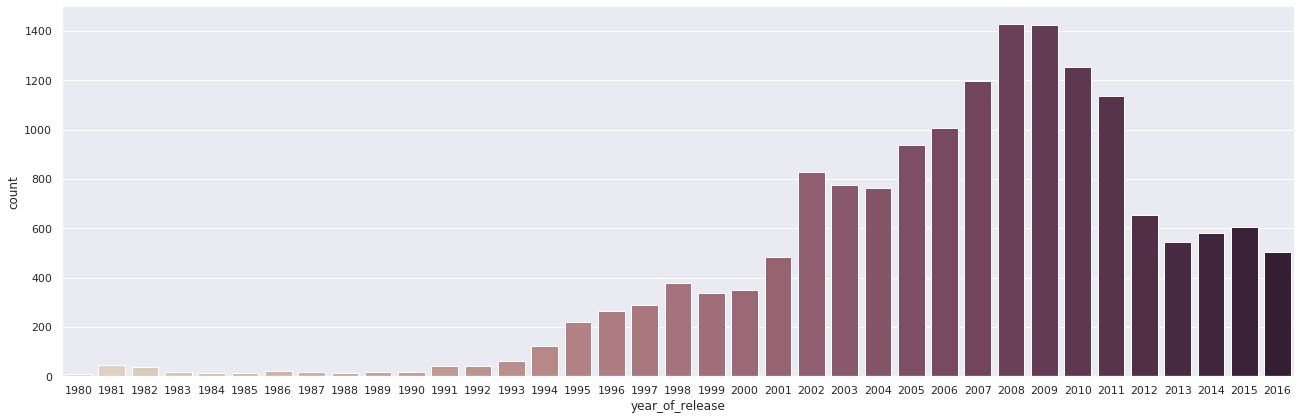

In [232]:
sns.catplot(x="year_of_release", kind="count", palette="ch:.25", height=6,
            aspect=3, data=df.query('year_of_release > 0'));

Расцвет игровой индустрии пришелся на 2008-2009 года, после чего кол-во выпускаемых игр начало заметно снижаться, что может быть связано с возросшими требованиями геймеров к контенту, повышением технологических возможностей платформ (а значит и усложнение разработки игр), а также с банальным финансовым кризисом, затронувшим все сферы жизни. Однако с 2013 года можно наблюдать появляющийся тренд на увеличение кол-ва выпускаемых игр (с учетом того, что данные за 2016 год не полные)

Посмотрим, как менялись **продажи по платформам**. Выберем платформы с наибольшими суммарными продажами и постром распределение по годам. Сразу оговоримся, что оценивать будем топ 10 платформ, выпущенных с 1994 года, т.к. исходя из распределения этот год можно назвать началом глобального развития игровой индустрии, до этого времени значения были несущетсвенными.

In [233]:
top_platforms = df.groupby('platform')[['sales']].agg('sum').sort_values(by='sales', ascending=False).head(10).index
top_platforms

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC'], dtype='object', name='platform')

Из общего датафрейма выберем только данные по топ 10 платформам, предварительно сгруппировав данные по самим платформам и по годам.

In [234]:
tp = (df.groupby(['platform', 'year_of_release'])[['sales']].sum().reset_index()
        .query('(platform in @top_platforms) & (year_of_release>1994)'))

In [235]:
ntp = tp.query('platform in @top_platforms')

Построим гисторграммы для каждой платформы.

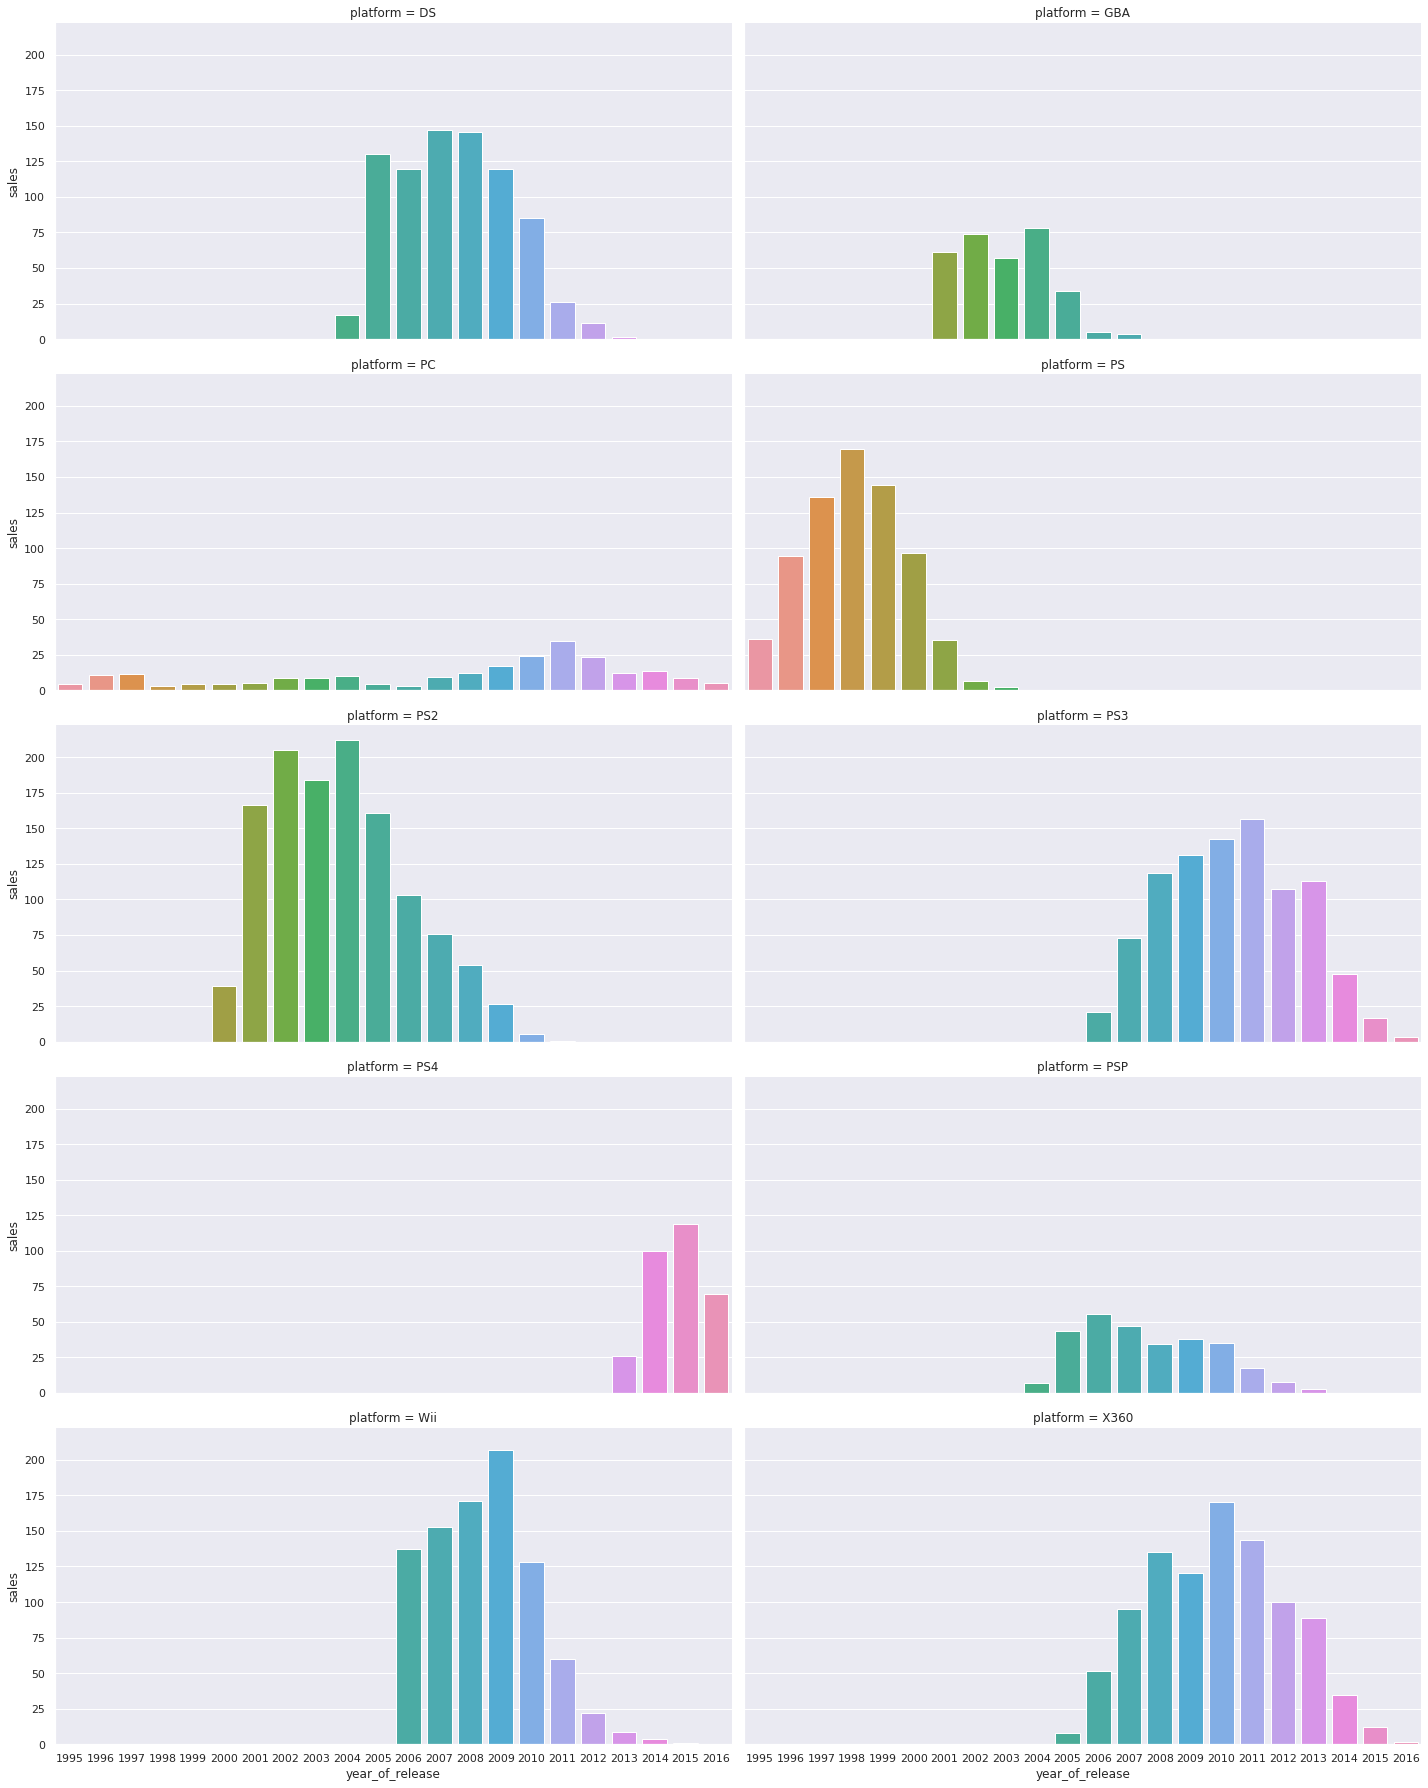

In [236]:
g = sns.catplot(x="year_of_release", y='sales', col="platform", col_wrap=2, kind='bar',
                data=tp, height=5, aspect=2)

По гистограммам хорошо заметен характерный жизненный цикл для каждой платформы, который составялет 6-8 лет. Исходя из этого можно определить актуальный период времени для оценки нынешней ситуации на рынке - с 2010 года.

Проведем похожий анализ только уже для актуального периода времени. для этого выберем из общего датафрейма игры, выпущенные после 2009 года.

In [237]:
act_df = df.query('year_of_release > 2009')
act_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5277 entries, 14 to 16714
Data columns (total 12 columns):
name               5277 non-null object
platform           5277 non-null object
year_of_release    5277 non-null int64
genre              5277 non-null object
na_sales           5277 non-null float64
eu_sales           5277 non-null float64
gp_sales           5277 non-null float64
other_sales        5277 non-null float64
critic_score       5277 non-null int64
user_score         5277 non-null float64
rating             5277 non-null object
sales              5277 non-null float64
dtypes: float64(6), int64(2), object(4)
memory usage: 535.9+ KB


Проведем аналогичные операции с новым актуальным датафреймом и посмотрим на распределение продаж по платформам.

In [238]:
new_top_platforms = act_df.groupby('platform')[['sales']].agg('sum').sort_values(by='sales', ascending=False).head(10).index

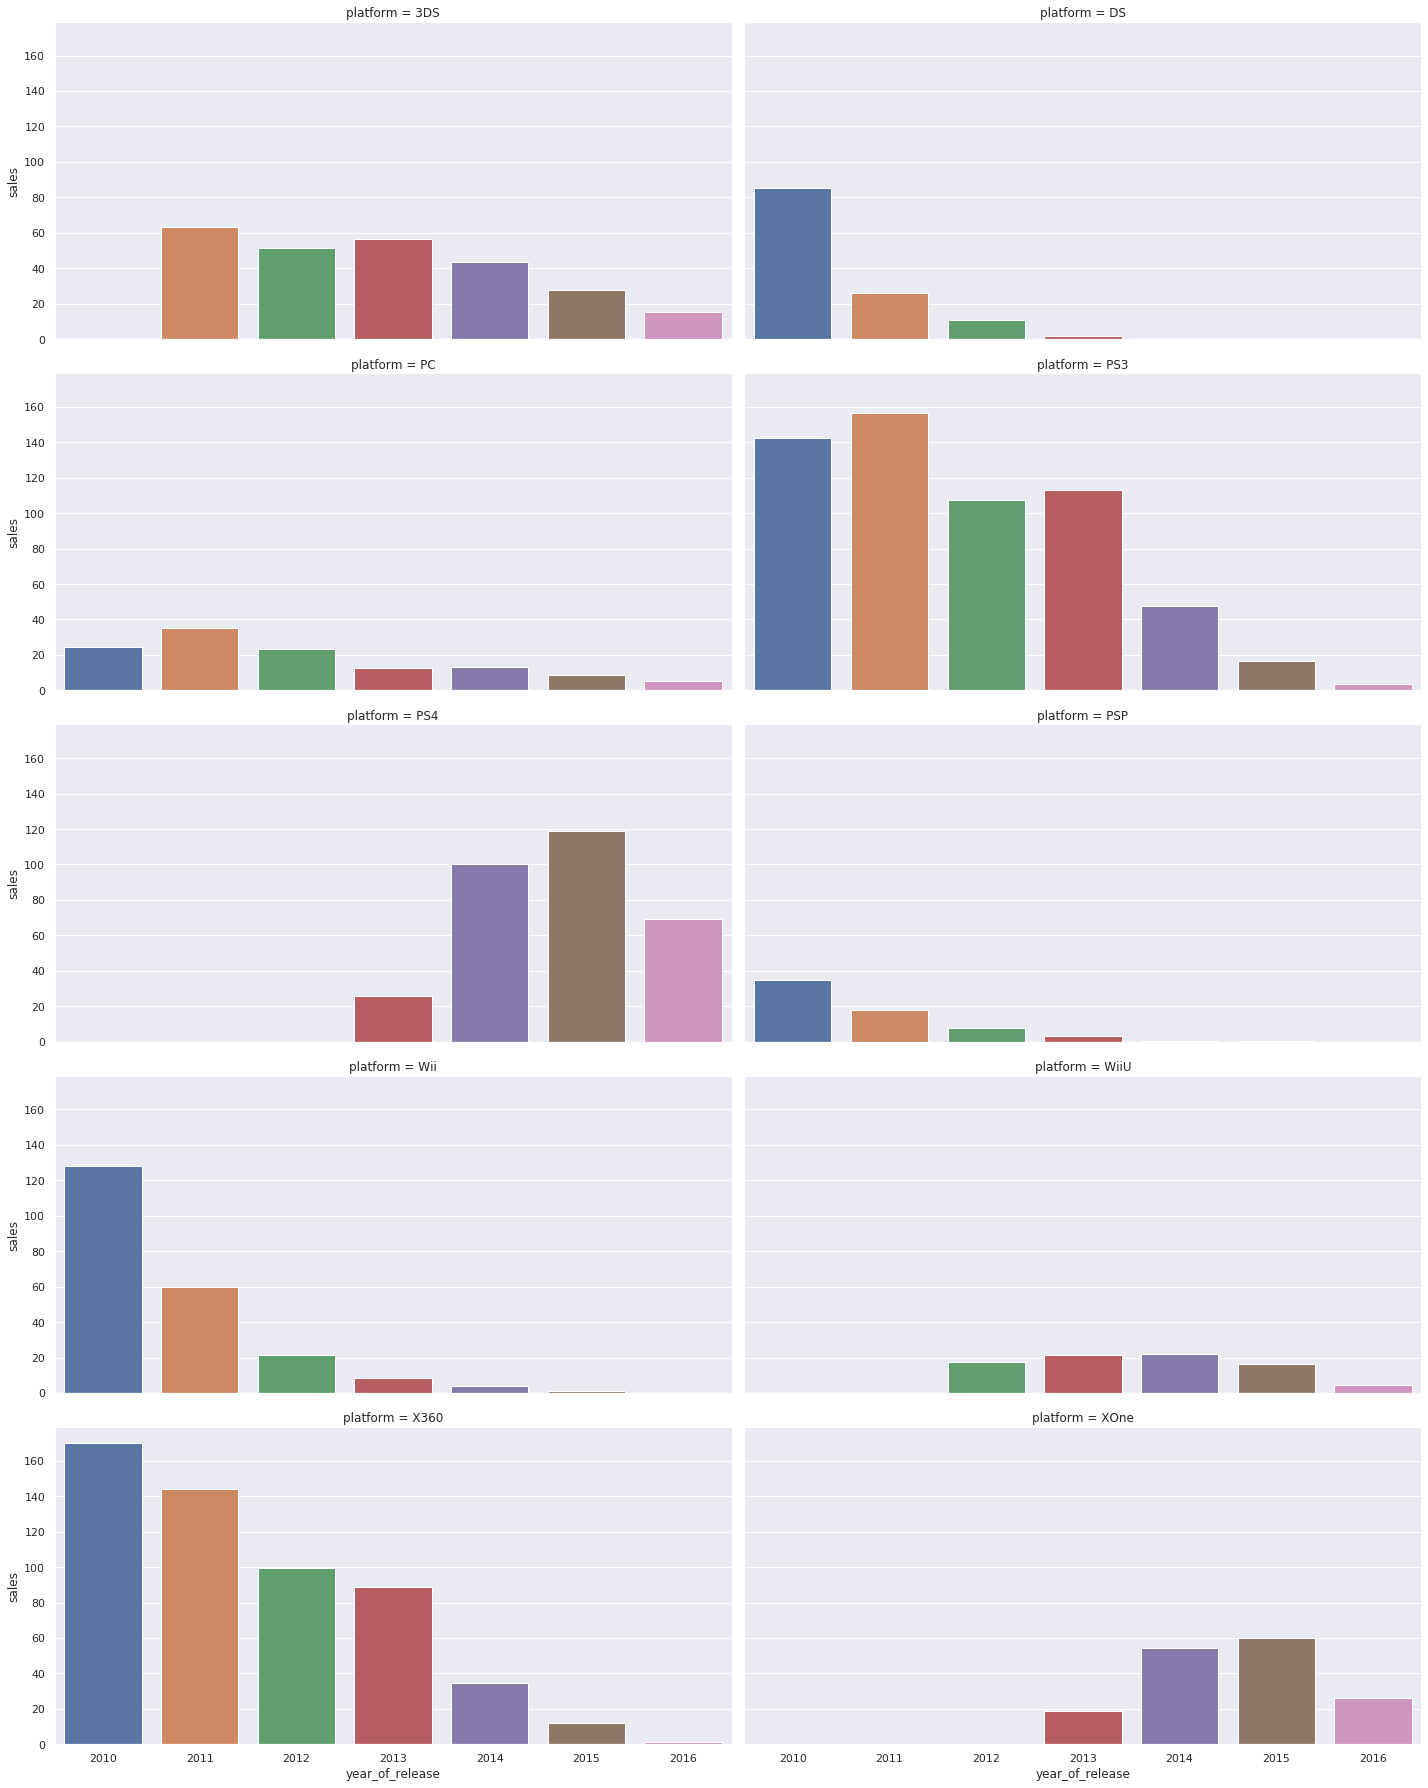

In [239]:
act_tp = (act_df.groupby(['platform', 'year_of_release'])[['sales']].sum().reset_index()
            .query('platform in @new_top_platforms'))
g = sns.catplot(x="year_of_release", y='sales', col="platform", col_wrap=2, kind='bar',
                data=act_tp, height=5, aspect=2)

Исходя из полученных распределений можно выделить две перспективные платформы - PlayStation 4 и XBox One. Все остальные либо доживают свой срок, либо уже изжили себя.
Выделим их из общего датафрейма и посмотрим на распределение глобальных продаж для каждой платформы.

In [240]:
persp_platforms = act_df.query('platform in ["PS4", "XOne"]')

In [241]:
persp_platforms[['name', 'platform', 'sales']].describe()

,sales
count,639.000000
mean,0.740939
std,1.416778
min,0.010000
25%,0.060000
50%,0.210000
75%,0.730000
max,14.630000


По общим данных хорошо заметна неоднородность продаж - в среднем глобальные продажи игр на этих двух платформах собирают порядка 740 тыс. долларов, тогда как стадартное отклонение 1,4 млн. долларов, а рекодсмен по продажам собрал более 14 млн $.
Для наглядности визуализируем диаграммы размаха для каждой платформы.

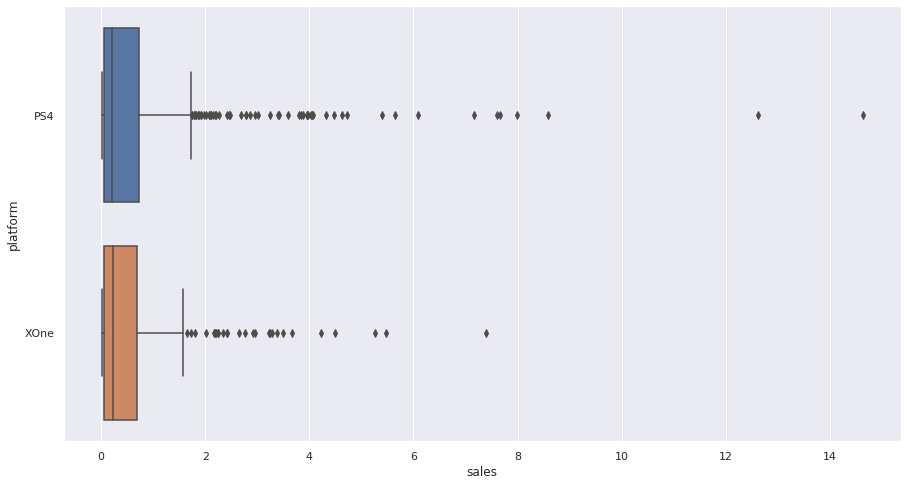

In [242]:
sns.boxplot(x='sales', y='platform', data=persp_platforms);

Здесь хорошо видно как бестселлеры смещают распределение, но эти данные нельзя назвать выбросами, это реальные цифры продаж, поэтому для большего понимания процессов около среднестатистической игры построим гистограммы по глобальным продажам для каждой платформы, ограничив продажи 2 млн $. (PS4 - *зеленый*, XOne - *синий*)

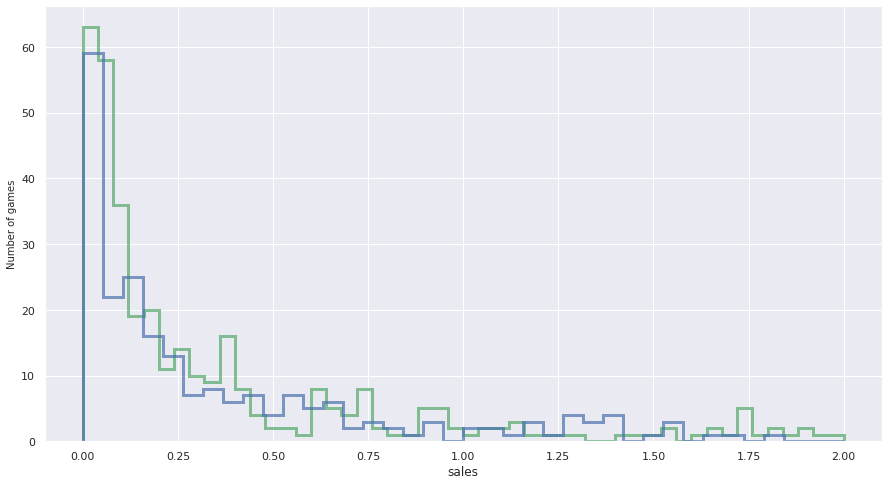

In [243]:
ps_4 = persp_platforms.query('platform == "PS4"')
x_one = persp_platforms.query('platform == "XOne"')
sns.set(rc={'figure.figsize':(15,8)})
sns.distplot(ps_4['sales'], kde=False, hist_kws={"histtype": "step", "range": (0,2), "linewidth": 3, 
                                                                 "alpha": .7, "color": "g"});
sns.distplot(x_one['sales'], kde=False, hist_kws={"histtype": "step", "range": (0,2), "linewidth": 3, 
                                                                 "alpha": .7, "color": "b"});
plt.ylabel('Number of games', fontsize=10);

Можно заметить, что распределения очень схожи (не считая того, что бестселлеры на PS4 собирают кратно больше) - большая часть игр почти не продаются, а хорошими глобальными продажами можно считать четверть миллиона долларов. 

In [244]:
ps_4[['sales']].describe() 

,sales
count,392.000000
mean,0.801378
std,1.609456
min,0.010000
25%,0.060000
50%,0.200000
75%,0.730000
max,14.630000


In [245]:
x_one[['sales']].describe() 

,sales
count,247.000000
mean,0.645020
std,1.036139
min,0.010000
25%,0.060000
50%,0.220000
75%,0.685000
max,7.390000


## Вывод: 

Cборы среднестатитстической игры на перспективных платформах PlayStation 4 и XBox One примерно одинаковые, но бестселлеры лучше продаются на PlayStation 4.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Учтем, что пропуски заполнены нетипичным значением -1.

In [246]:
ps_4_users = ps_4.query('user_score > 0')
ps_4_critic = ps_4.query('critic_score > 0')
x_one_users = x_one.query('user_score > 0')
x_one_critic = x_one.query('critic_score > 0')

Разобьем рейтинг на 5 категорий:
- от 0 до 2 - очень низкий
- от 2 до 4 - низкий
- от 4 до 6 - средний
- от 6 до 8 - высокий
- от 8 до 10 - шедевр

Для этого подготовим функцию, которая создаст новые столбцы с категориями оценок (предварительно умножим оценки пользователей на 10, чтобы привести их к единообразному виду).

In [247]:
persp_platforms = (persp_platforms.query('(user_score > 0) & (critic_score > 0)')
                   .sort_values(by='critic_score'))
persp_platforms['user_score'] = persp_platforms['user_score'].apply(lambda x: (x*10))

In [248]:
def score_type(score):
    if score < 20:
        return '0-2'
    if score < 40:
        return '2-4'
    if score < 60:
        return '4-6'
    if score < 80:
        return '6-8'
    else:
        return '8-10'

persp_platforms['critic_score_type'] = persp_platforms['critic_score'].apply(score_type)
persp_platforms['user_score_type'] = persp_platforms['user_score'].apply(score_type)

Построим распределения средних продаж по каждой из категории оценок по каждой платформе, в зависимости от оценок критиков.

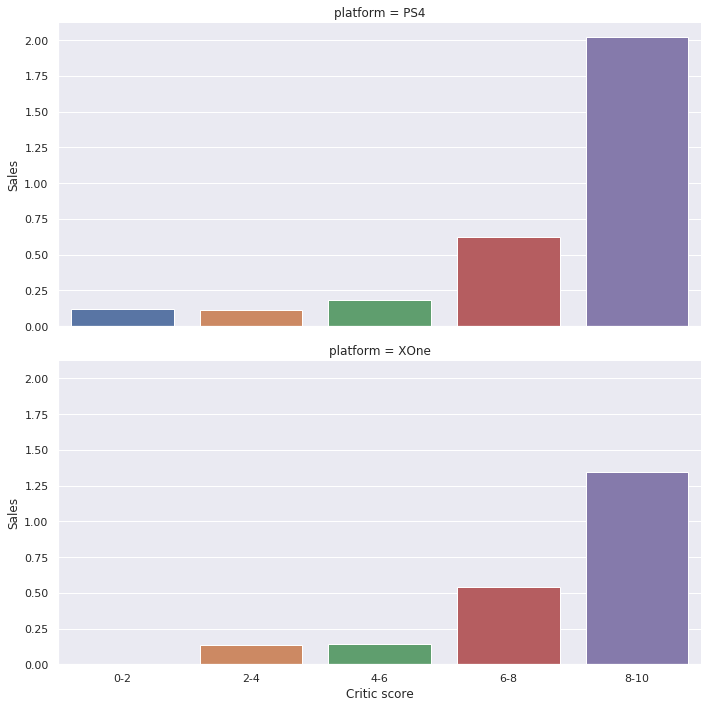

In [249]:
fig = sns.catplot(x="critic_score_type", y='sales', col="platform", col_wrap=1, kind='bar', ci=.01,
                data=persp_platforms, height=5, aspect=2);
fig.set_axis_labels("Critic score", "Sales");

По гистограмме хорошо видна прямая зависимость - чем выше оценка критиков, тем выше продажи (что довольно логично)

Теперь тоже самое для оценок пользователей:

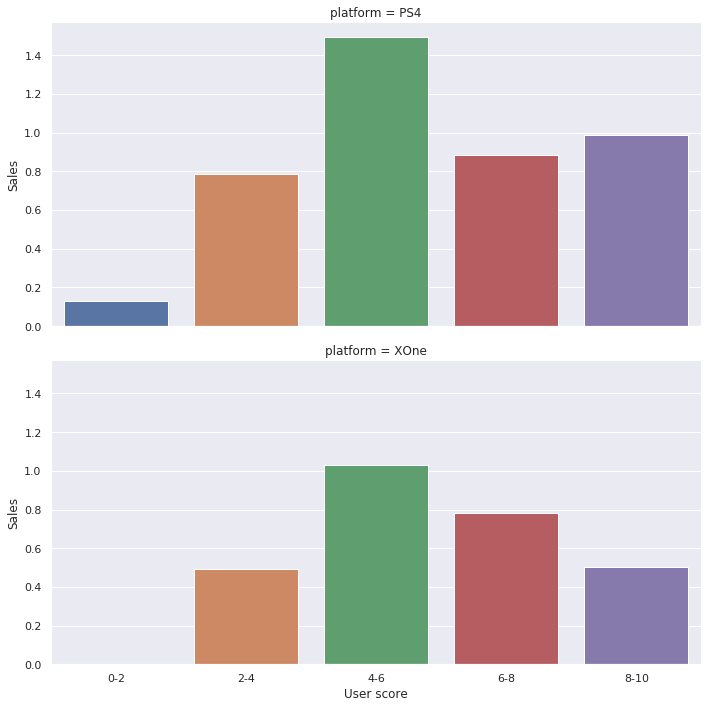

In [250]:
f = sns.catplot(x="user_score_type", y='sales', col="platform", col_wrap=1, kind='bar', ci=.01,
                data=persp_platforms.sort_values(by='user_score'), height=5, aspect=2);
f.set_axis_labels("User score", "Sales");

Оценки пользователей уже не так явно показывают средние продажи. 

Для более точной оценки посчитаем коэффициенты корреляции  оценок с глобальными продажами:

**PlayStation 4:**

1) Пользовательские оценки:

In [150]:
ps_4_users['user_score'].corr(ps_4_users['sales'])

-0.031957110204556424

2) Оценки критиков:

In [151]:
ps_4_critic['critic_score'].corr(ps_4_critic['sales'])

0.40656790206178095

**XBox One:**

1) Пользовательские оценки: 

In [152]:
x_one_users['user_score'].corr(x_one_users['sales'])

-0.06892505328279414

2) Оценки критиков:

In [153]:
x_one_critic['critic_score'].corr(x_one_critic['sales'])

0.4169983280084017

### Вывод:

Оценки критиков показывают среднюю корреляцию с глобальными продажами игр (на них можно опираться при определении потенциально популярного продукта). Пользователи же в свою очередь не так очевидно оценивают игры (на их оценку можно и нужно смотреть, только если она очень низкая - от 0 до 2)

Теперь соотнесем полученные выводы с продажами игр на других платформах. Для этого проведем аналогичные действия и построим гистограммы по пользователевским оценкам:

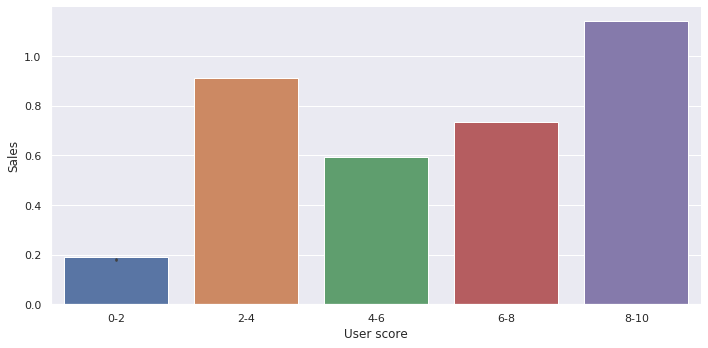

In [251]:
other_platforms = act_df.query('platform not in ["PS4", "XOne"]')
other_platforms = (other_platforms.query('(user_score > 0) & (critic_score > 0)')
                   .sort_values(by='critic_score'))
other_platforms['user_score'] = other_platforms['user_score'].apply(lambda x: (x*10))
other_platforms['critic_score_type'] = other_platforms['critic_score'].apply(score_type)
other_platforms['user_score_type'] = other_platforms['user_score'].apply(score_type)
y = sns.catplot(x="user_score_type", y='sales', kind='bar', ci=.01,
                data=other_platforms.sort_values(by='user_score'), height=5, aspect=2);
y.set_axis_labels("User score", "Sales");

и по оценкам критиков:

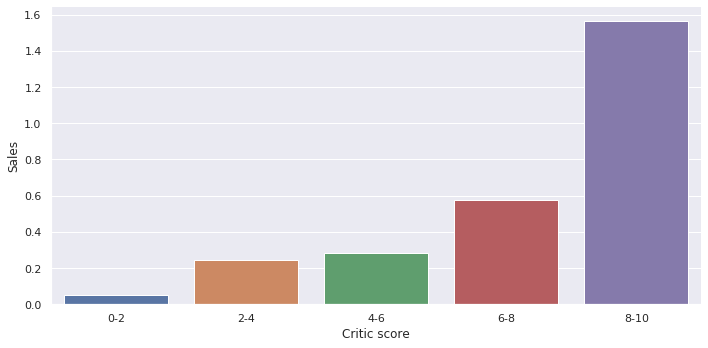

In [252]:
z = sns.catplot(x="critic_score_type", y='sales', kind='bar', ci=.01,
                data=other_platforms.query('(user_score > 0) & (critic_score > 0)'), height=5, aspect=2);
z.set_axis_labels("Critic score", "Sales");

В общем и целом ситуация похожая и для остальных платформ, лучше всего ориентироваться на оценку критиков.

Посмотрим на общее распределение игр по жанрам. Для этого сделаем сводную таблицу, в которой оценим средние глобальные продажи по каждому из жанров.

In [253]:
genre = (act_df.query('genre != "unknown"')
         .groupby('genre')[['sales']].agg('mean').sort_values(by='sales', ascending=False))
genre

,sales
genre,
Shooter,1.170098
Platform,0.782484
Sports,0.571113
Role-Playing,0.555070
Racing,0.517637
Action,0.450227
Fighting,0.410000
Misc,0.407222
Simulation,0.330645


Построим диаграммы размаха для Топ 3 жанров: Шутеры, платформеры и спортивные игры.

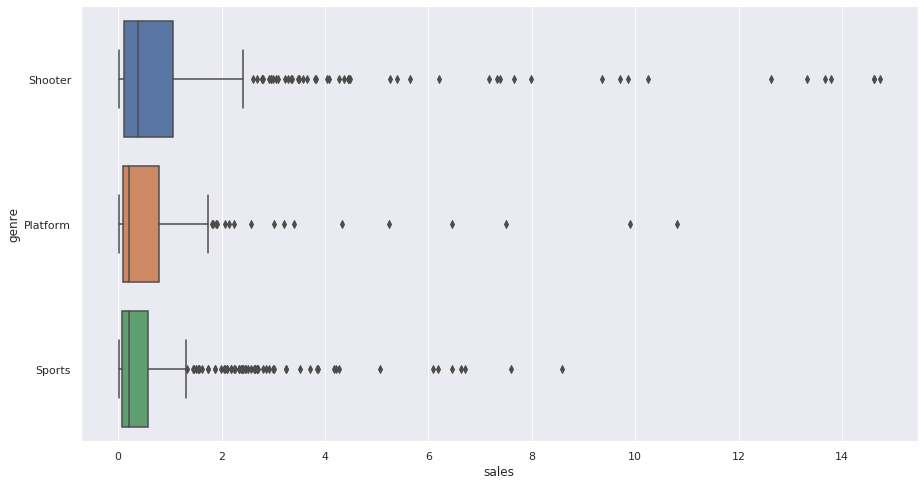

In [255]:
sns.boxplot(x='sales', y='genre', data=act_df.query('genre in ["Shooter", "Platform", "Sports"]'));

### Вывод.

Самыми прибыльными жанрами являются шутеры, платформеры и спортивные игры. При этом медианные продажи заметно выше только у шутеров.

**Составим портрет пользователя каждого региона (NA, EU, JP)**

Определим для пользователя каждого региона (NA, EU, JP):
-	Самые популярные платформы (топ-5). 
-	Самые популярные жанры (топ-5). 
-	Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Создадим функцию, которая на вход принимает необходимый нам датафрейм и столбец, который показывает продажи по конкретному региону. Результатом работы такой функции будут 3 круговые диаграммы, показывающие распределение продаж между топ 5 платформами, жанрами и рейтингом ESRB.

In [257]:
def region(df, region):
    top_pl = df.pivot_table(index='platform', values=region, aggfunc='sum').sort_values(by=region, ascending=False).head()
    top_genre = df.pivot_table(index='genre', values=region, aggfunc='sum').sort_values(by=region, ascending=False).head()
    esrb = (df.query('rating != -1')
           .pivot_table(index='rating', values=region, aggfunc='sum').sort_values(by=region, ascending=False))
    labels_pl = top_pl.index
    labels_genre = top_genre.index
    labels_esrb = esrb.index
    fig, ax = plt.subplots(1, 3, figsize=[16, 7])
    ax[0].pie(top_pl[region], labels=labels_pl, autopct='%1.1f%%')
    ax[0].set_title('Top 5 Platforms %')
    ax[1].pie(top_genre[region], labels=labels_genre, autopct='%1.1f%%')
    ax[1].set_title('Top 5 Genres %')
    ax[2].pie(esrb[region], labels=labels_esrb, autopct='%1.1f%%')
    ax[2].set_title('ESRB rating %')

**Для Северной Америки:**

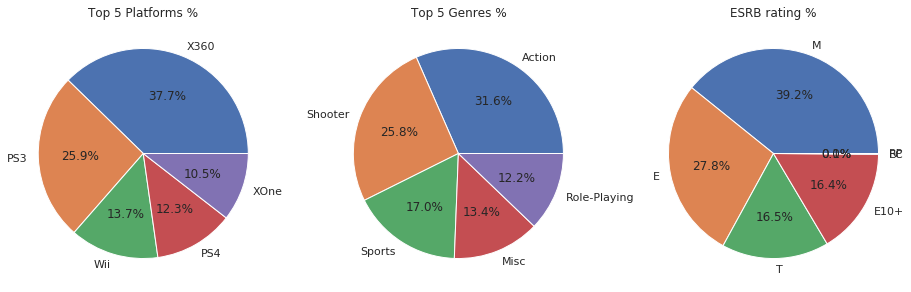

In [258]:
region(act_df, 'na_sales')

**Для Европы:**

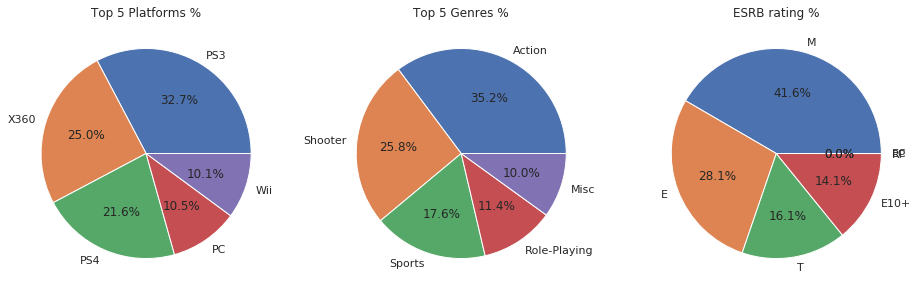

In [259]:
region(act_df, 'eu_sales')

**Для Японии:**

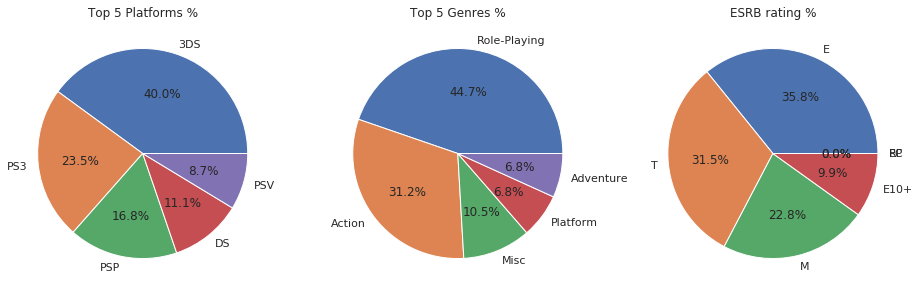

In [260]:
region(act_df, 'gp_sales')

### Вывод.

1) В Евпопе и Северной Америке очень схожие игровые привычки пользователей:

- преобладают PS 3 и X360 (более 50%)
- любимые жанры - шутеры и экнш-игры
- лучше всего продаются игры с рейтингом M (для взрослых)

2) Японский игровой рынок совершенно другой:

- ключевая платформа 3DS, также стоит отметить высокий процент PSP - в основном японцы играют на портативных платформах
- отсюда вытекает и огромная доля ролевых игр, относительно остальных
- лучше всего продаются игры с рейтингом Е (для всех - от 6 лет и старше)

# Проверка гипотез.

**Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Перед проверкой гипотез проверим дисперсии для пользовательских рейтингов по обеим платформам.

In [261]:
good_df = df.query('user_score > 0')
def var(measure):
    variance = round(np.var(measure), 1)
    return variance
var(good_df.query('platform == "XOne"')['user_score'])

1.9

In [262]:
var(good_df.query('platform == "PC"')['user_score'])

2.3

Изначально можно было предположить, что разница не должна быть существенной, однако она присутствует, учтем это при проверке гипотезы.

Сформулируем нулевую гипотезу - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная - Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Т.к. мы проверяем гипотезу о равенстве средних двух независимых генеральных совокупностей, то будем применять критерий Стьюдента.

Также мы уже знаем, что дисперсии выборок по платформам различны, поэтому в качестве параметра передадим *equal_var = False*

Пороговое значение альфа зададим как 5%.

In [267]:
score_x_one = good_df.query('platform == "XOne"')['user_score']
score_pc = good_df.query('platform == "PC"')['user_score']
alpha = .05
results = st.ttest_ind(
    score_x_one, 
    score_pc,
    equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.935072360183565e-06
Отвергаем нулевую гипотезу


Исходя из статистики разности, можно сделать вывод о том, что средние пользовательские рейтинги у платформ различаются, вероятность равенства крайне мала - **нулевая гипотеза отвергнута**.

**Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные.**

Сформулируем нулевую гипотезу - Средние пользовательские рейтинги жанров Action и Sports равны.

Альтернативная - Средние пользовательские рейтинги жанров Action и Sports различаются.

Здесь используется аналогичный предыдущему метод оценки.

In [268]:
var(good_df.query('genre == "Action"')['user_score'])

2.0

In [269]:
var(good_df.query('genre == "Sports"')['user_score'])

2.6

Дисперсии выборок различны, поэтому проводим аналагочный предыдущему анализ.

In [270]:
score_action = good_df.query('genre == "Action"')['user_score']
score_sports = good_df.query('genre == "Sports"')['user_score']
alpha = .05
results = st.ttest_ind(
    score_action, 
    score_sports,
    equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11483818791498286
Не получилось отвергнуть нулевую гипотезу


В данном случае нулевую гипотезу отвергнуть не получилось, что говорит нам о том, что с достаточной долей вероятности средние пользовательские рейтинги этих двух жанров могут быть равны.

# Общий вывод.

В данной работе были проведены следующие этапы:

- обнаружены и исправлены пропуски в данных;
- изменены типы данных;
- проведен анализ распределения игр по годам, найден актуальный период;
- найдены перпективные платформы;
- проведен анализ глобальных продаж на этих платформах;
- проведена оценка влияния оценок критиков и пользователей на глобальные продажи;
- найдены самые прибыльные жанры;
- составлен портрет пользователя по каждому региону (Северная Америка, Европа и Япония);
- проверены следующие гипотезы:

    1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

    2) Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

В результате можно сделать несколько основных выводов:

    1) Период жизни игровой платформы 6-8 лет;
    2) На данный момент есть только две перпективные платформы - PS 4 и XBox One;
    3) Глобальные продажи на обеих платформах распределены похожим образом, но в целом игры на PS 4 продаются лучше (в основном за счет бестселлеров);
    4) Оценка критиков влияет на продажи в большей степени, чем оценка пользователей;
    5) Самыми прибыльными жанрами можно назвать шутеры, платформеры и спортивные игры;
    6) Рынок игр в Северной Америке и Европе очень схожий, в Японии же присутсвуют сильные отличия в приоритетах пользователей (предпочтение портативных платформ);
    7) Гипотеза о равенстве пользовательских рейтингов платформ Xbox One и PC отвергнута;
    8) Гипотезу о равенстве пользовательских рейтингов жанров Action и Sports отвергнуть не удалось.